<a href="https://colab.research.google.com/github/yamanmy/Automated_image_tool_for_Au_PF_image/blob/main/Automated_image_tool_for_Au_PF_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyzing SEM images of Au Nanoparticles and Protein Fibers

Created by: 

Muammer Yusuf Yaman yamanmy@uw.edu

Maxim Ziatdinov 

Sergei V. Kalinin

David Ginger


In this colab page, an automated image analysis tool has developed to analyze Scaning Electron Microscopy (SEM) images of Au nanorods and *de novo* synthesized protein fibers. 

The goal of this tool is automatically recognize the protein fibers and Au nanorods from SEM images,and then quantitatively calculate *specific* vs *nonspecific* Au nanorods attachment to protein fiber or substrate, respectively. The automated tool also provides additional information concerning the angle of each Au nanorod on protein,the size distribution of Au nanorods, the length of protein fibers and so on.

The workflow of the image analysis tool:

1-First step is to import required modules

2-Second step is to load SEM images and define pixel size according to known value (need to check each image if scale bar is changed)

3-Third step is to identify Au nanoparticles using image processing in OpenCV and Scikit-image.
Particle size distrubitons of Au NRs were calculated in terms of aspect ratio and particle covered area. 

4-Fourth step is to identify Protein Fibers, which is black line in the SEM images. We used ML to determine protein fibers instead of hand labeling.We trained our model using another Colab page. Here, we are using the pre-trained model to predict and idnetify the protein fibers. (We need to import new tranined model here!!!)

5-Fifth step is to regenerate images from the outputs of third and fourth step to count the number of Au NRs on Protein Fiber and to calculate angle of Au NRs with respect to Protein Fibers. 





## 1- Import required modules

In [1]:
#@title Import modules
# Data manipulation and plotting
import os
import math
import time
import numpy as np
from collections import OrderedDict
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.preprocessing import StandardScaler
from scipy import ndimage, spatial
import cv2
import imageio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skimage import feature
from skimage import morphology
from scipy import ndimage as ndi

from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage.transform import resize

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from __future__ import division 

# Neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#@title Load custom modules 1 { form-width: "20%" }

def load_torchmodel(weights_path, model):
    '''Loads saved weights into a model'''
    if torch.cuda.device_count() > 0:
        checkpoint = torch.load(weights_path)
    else:
        checkpoint = torch.load(weights_path, map_location='cpu')
    model.load_state_dict(checkpoint)
    return model
    
class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output

class dilation_block(nn.Module):
    '''
    Creates a block with dilated convolutional
    layers (aka atrous convolutions)
    '''
    def __init__(self, input_channels, output_channels,
                 dilation_values, padding_values,
                 kernel_size=3, stride=1, lrelu_a=0.01,
                 use_batchnorm=False, dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            dilation_values: list of dilation rates for convolution operation
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
            '''
        super(dilation_block, self).__init__()
        atrous_module = []
        for idx, (dil, pad) in enumerate(zip(dilation_values, padding_values)):
            input_channels = output_channels if idx > 0 else input_channels
            atrous_module.append(nn.Conv2d(input_channels,
                                           output_channels,
                                           kernel_size=kernel_size,
                                           stride=stride,
                                           padding=pad,
                                           dilation=dil,
                                           bias=True))
            if dropout_ > 0:
                atrous_module.append(nn.Dropout(dropout_))
            atrous_module.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                atrous_module.append(nn.BatchNorm2d(output_channels))
        self.atrous_module = nn.Sequential(*atrous_module)

    def forward(self, x):
        '''Forward path'''
        atrous_layers = []
        for conv_layer in self.atrous_module:
            x = conv_layer(x)
            atrous_layers.append(x.unsqueeze(-1))
        return torch.sum(torch.cat(atrous_layers, dim=-1), dim=-1)

class upsample_block(nn.Module):
    '''
    Defines upsampling block performed either with
    bilinear interpolation followed by 1-by-1
    convolution or with a transposed convolution
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size = kernel_size,
            stride = stride, padding = padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding = 0)

    def forward(self, x):
        '''Defines a forward path'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)



class atomsegnet(nn.Module):
    '''
    Builds  a fully convolutional neural network model
    '''
    def __init__(self, nb_classes=1, nb_filters=32):
        '''
        Args:
            nb_filters: number of filters in the first convolutional layer
        '''
        super(atomsegnet, self).__init__()
        self.pxac = 'sigmoid' if nb_classes < 2 else 'softmax'
        self.c1 = conv2dblock(1, nb_filters)
        
        self.c2 = nn.Sequential(conv2dblock(nb_filters,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.c3 = nn.Sequential(conv2dblock(nb_filters*2,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.bn = dilation_block(nb_filters*4,
                                 nb_filters*8,
                                 dilation_values=[2, 4, 6],
                                 padding_values=[2, 4, 6],
                                 dropout_=0.5)
        
        self.upsample_block1 = upsample_block(nb_filters*8,
                                              nb_filters*4)
        
        self.c4 = nn.Sequential(conv2dblock(nb_filters*8,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.upsample_block2 = upsample_block(nb_filters*4,
                                              nb_filters*2)
        
        self.c5 = nn.Sequential(conv2dblock(nb_filters*4,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.upsample_block3 = upsample_block(nb_filters*2,
                                              nb_filters)
        
        self.c6 = conv2dblock(nb_filters*2,
                              nb_filters)
        
        self.px = nn.Conv2d(nb_filters,
                            nb_classes,
                            kernel_size=1,
                            stride=1,
                            padding=0)
               
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        c3 = self.c3(d2)
        d3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        # Atrous convolutions
        bn = self.bn(d3)
        # Expanding path
        u3 = self.upsample_block1(bn)
        u3 = torch.cat([c3, u3], dim=1)
        u3 = self.c4(u3)
        u2 = self.upsample_block2(u3)
        u2 = torch.cat([c2, u2], dim=1)
        u2 = self.c5(u2)
        u1 = self.upsample_block3(u2)
        u1 = torch.cat([c1, u1], dim=1)
        u1 = self.c6(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output


def torch_format(images, norm=1):
    '''Reshapes dimensions, normalizes (optionally)
       and converts image data to a pytorch float tensor.
       (assumes mage data is stored as numpy array)'''
    if images.ndim == 2:
        images = np.expand_dims(images, axis=0)
    images = np.expand_dims(images, axis=1)
    if norm != 0:
        images = (images-np.amin(images))/np.ptp(images)
    images = torch.from_numpy(images).float()
    return images


def predict(images, model, use_gpu=False):
    '''Returns probability (as seen by neural network)
    of each pixel in image belonging to a defect'''
    if use_gpu:
        model.cuda()
        images = images.cuda()
    model.eval()
    with torch.no_grad():
        prob = model.forward(images)
    if use_gpu:
        model.cpu()
        images = images.cpu()
        prob = prob.cpu()
    prob = prob.permute(0, 2, 3, 1)
    return prob


def threshold_output(imgdata, t=0.5):
    '''Binary threshold of an output of a neural network'''
    imgdata_ = cv2.threshold(imgdata, t, 1, cv2.THRESH_BINARY)[1]
    return imgdata_

def filter_single_frame(imgdata, output_thresh, size_thresh):
    '''Filters out blobs above cetrain size
    in the thresholded neural network output'''
    imgdata = threshold_output(imgdata, output_thresh)
    label_img, cc_num = ndimage.label(imgdata)
    cc_areas = ndimage.sum(imgdata, label_img, range(cc_num + 1))
    area_mask = (cc_areas < size_thresh)
    label_img[area_mask[label_img]] = 0
    label_img[label_img > 0] = 1
    return label_img

def filter_cells(imgdata, output_thresh=0.5, size_thresh=20):
    '''Filters blobs for each image in the stack'''
    filtered_stack = np.zeros_like(imgdata)
    for i, img in enumerate(imgdata):
        filtered_stack[i] = filter_single_frame(img, output_thresh, size_thresh)
    return filtered_stack

def find_blobs(imgdata):
    '''Finds position of defects in the processed output
       of a neural network via center of mass method'''
    labels, nlabels = ndimage.label(imgdata)
    coordinates = ndimage.center_of_mass(
        imgdata, labels, np.arange(nlabels)+1)
    coordinates = np.array(coordinates, dtype=np.float)
    coordinates = coordinates.reshape(coordinates.shape[0], 2)
    return coordinates


def remove_edge_coord(imgdata, coordinates, dist_edge=20):
    '''Removes coordinates too close to image edges'''
    def coord_edges(coordinates, w, h, dist_edge):
        return [coordinates[0] > w - dist_edge,
                coordinates[0] < dist_edge,
                coordinates[1] > h - dist_edge,
                coordinates[1] < dist_edge]
    w, h = imgdata.shape[0:2]
    coord_to_rem = [idx for idx, c in enumerate(coordinates) if
                    any(coord_edges(c, w, h, dist_edge))]
    coord_to_rem = np.array(coord_to_rem, dtype=int)
    coordinates = np.delete(coordinates, coord_to_rem, axis=0)
    return coordinates

def get_contours(imgdata):
    """Extracts contours from image data (image data must be binary thresholded)"""
    imgdata_ = cv2.convertScaleAbs(imgdata)
    contours = cv2.findContours(
        imgdata_.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
    return contours

def get_trajectories(exp_images, network_output):
    """Extracts position and angle for each particle for each movie frame"""
    trajectories = {}
    for i, frame in enumerate(network_output):
        contours = get_contours(frame)
        dictionary = OrderedDict()
        com_arr = np.empty((0, 2))
        angles = []
        for cnt in contours:
            try:
                (com), _, angle = cv2.fitEllipse(cnt)
            except:
                continue
            com = np.array(com)
            com_arr = np.append(com_arr, [com], axis=0)
            angles.append(angle)
        dictionary['experimental'] = exp_images[i, 0, :, :]
        dictionary['decoded'] = frame
        dictionary['coordinates'] = com_arr
        dictionary['angles'] = np.array(angles)
        trajectories[i] = dictionary
    return trajectories


class dl_image:
    '''
    Image decoder with a trained neural network
    '''
    def __init__(self, image_data, model, *args, nb_classes=1,
                 max_pool_n=3, norm=1, use_gpu=False,
                 histogram_equalization=False):
        '''
        Args:
            image_data (ndarray): image stack or a single image (all greyscale)
            model: trained pytorch model
            nb_classes: number of classes in the model
            max_pool_n: number of max-pooling layers in the model
            norm: image normalization to 1
            use_gpu: optional use of gpu device for inference
            histogram_equalization: Equilazes image histogram
            args: tuple with image width and heigh for resizing operation
        '''
        if image_data.ndim == 2:
            image_data = np.expand_dims(image_data, axis=0)
        self.image_data = image_data
        try:
            self.rs = args[0]
        except IndexError:
            self.rs = image_data.shape[1:3]
        self.model = model
        self.nb_classes = nb_classes
        self.max_pool_n = max_pool_n
        self.norm = norm
        self.use_gpu = use_gpu
        self.hist_equ = histogram_equalization
    
    def img_resize(self):
        '''Image resizing (optional)'''
        if self.image_data.shape[1:3] == self.rs:
            return self.image_data.copy()
        image_data_r = np.zeros((self.image_data.shape[0],
                                 self.rs[0], self.rs[1]))
        for i, img in enumerate(self.image_data):
            img = cv2.resize(img, (self.rs[0], self.rs[1]))
            image_data_r[i, :, :] = img
        return image_data_r
        
    def img_pad(self, *args):
        '''Pads the image if its size (w, h)
        is not divisible by 2**n, where n is a number
        of max-pooling layers in a network'''
        try:
            image_data_p = args[0]
        except IndexError:
            image_data_p = self.image_data
        # Pad image rows (height)
        while image_data_p.shape[1] % 2**self.max_pool_n != 0:
            d0, _, d2 = image_data_p.shape
            image_data_p = np.concatenate(
                (image_data_p, np.zeros((d0, 1, d2))), axis=1)
        # Pad image columns (width)
        while image_data_p.shape[2] % 2**self.max_pool_n != 0:
            d0, d1, _ = image_data_p.shape
            image_data_p = np.concatenate(
                (image_data_p, np.zeros((d0, d1, 1))), axis=2)

        return image_data_p

    def hist_equalize(self, *args, number_bins=5):
        '''Histogram equalization (optional)'''
        try:
            image_data_ = args[0]
        except IndexError:
            image_data_ = self.image_data
     
        def equalize(image):
            image_hist, bins = np.histogram(image.flatten(), number_bins)
            cdf = image_hist.cumsum()
            #cdf_normalized = cdf * image_hist.max()/ cdf.max()
            image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
            return image_equalized.reshape(image.shape)

        image_data_h = np.zeros(shape=image_data_.shape)
        for i, img in enumerate(image_data_):
            img = equalize(img)
            image_data_h[i, :, :] = img

        return image_data_h


    def torch_format(self, image_data_):
        '''Reshapes and normalizes (optionally) image data
        to make it compatible with pytorch format'''
        image_data_ = np.expand_dims(image_data_, axis=1)
        if self.norm != 0:
            image_data_ = (image_data_ - np.amin(image_data_))/np.ptp(image_data_)
        image_data_ = torch.from_numpy(image_data_).float()
        return image_data_
    
    def predict(self, images):
        '''Returns probability of each pixel
           in image belonging to an atom'''
        if self.use_gpu:
            self.model.cuda()
            images = images.cuda()
        self.model.eval()
        with torch.no_grad():
            prob = self.model.forward(images)
            if self.nb_classes > 1:
                prob = torch.exp(prob)
        if self.use_gpu:
            self.model.cpu()
            images = images.cpu()
            prob = prob.cpu()
        prob = prob.permute(0, 2, 3, 1) # reshape with channel=last as in tf/keras
        prob = prob.numpy()

        return prob
    
    def decode(self):
        '''Make prediction'''
        image_data_ = self.img_resize()
        if self.hist_equ:
            image_data_ = self.hist_equalize(image_data_)
        image_data_ = self.img_pad(image_data_)
        image_data_torch = self.torch_format(image_data_)
        start_time = time.time()
        if image_data_torch.shape[0] < 20 and min(image_data_torch.shape[2:4]) < 512:
            decoded_imgs = self.predict(image_data_torch)
        else:
            n, _, w, h = image_data_torch.shape
            decoded_imgs = np.zeros((n, w, h, self.nb_classes))
            for i in range(n):
                decoded_imgs[i, :, :, :] = self.predict(image_data_torch[i:i+1])
        n_images_str = " image was " if decoded_imgs.shape[0] == 1 else " images were "
        print(str(decoded_imgs.shape[0]) + n_images_str + "decoded in approximately "
              + str(np.around(time.time() - start_time, decimals=2)) + ' seconds')
        image_data_torch = image_data_torch.permute(0, 2, 3, 1)
        images_numpy = image_data_torch.numpy()
        return images_numpy, decoded_imgs

def make_animation(trajectories, figdir, moviename):
    '''
    Creates and saves a gif animation from decoded "movie" data
    
    Args:
        img: 3D numpy array
            Experimental data
        dec: 3D numpy array
            Neural network output
        coord: dict
            Coordinates of atoms in each frame (key: frame number)
        figdir: string
            Directory for saving individual frames and gif animation
        moviename: string
            Name of animation file
    '''
    # Create new directory
    if not os.path.exists(figdir):
        os.makedirs(figdir)  
    # Store movie frames as .png files in the new directory
    fig = plt.figure(figsize = (12, 12), dpi = 100)
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    for k in range(len(trajectories)):
        #for _ax in fig.axes:
        #    _ax.cla()
        experimental, decoded, coordinates, angles = trajectories[k].values()
        angles = np.array([math.radians(i) for i in angles])
        angles = angles%math.pi
        x, y = coordinates.T
        ax1.imshow(experimental , cmap = 'gray')
        ax1.set_title('Experimental image')
        ax2.imshow(experimental, cmap = 'gray')
        ax2.imshow(decoded, cmap = 'jet', Interpolation = 'Gaussian', alpha=1.)
        ax2.set_title('Model prediction')
        ax3.quiver(x, y, np.sin(angles), np.cos(angles), color='black')
        ax3.set_xlim(0, 512)
        ax3.set_ylim(512, 0)
        ax3.set_title('Proteins position and orientation')
        for _ax in fig.axes:
            _ax.axis('off')
        fig.savefig(os.path.join(figdir, 'frame-{}.png'.format(k)))
        for _ax in fig.axes:
            _ax.cla()
        plt.close(fig)
    # Read saved movie frames and save them as .gif animation
    images = []
    for file_name in os.listdir(figdir):
        if file_name.endswith('.png'):
            images.append(imageio.imread(os.path.join(figdir, file_name)))
    imageio.mimsave(os.path.join(figdir, moviename + '.gif'), images)
    return

#@title Load model(s) skeleton { form-width: "20%" }

def load_torchmodel(weights_path, model):
    '''Loads saved weights into a model'''
    if torch.cuda.device_count() > 0:
        checkpoint = torch.load(weights_path)
    else:
        checkpoint = torch.load(weights_path, map_location='cpu')
    model.load_state_dict(checkpoint)
    return model
    
class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output

class dilation_block(nn.Module):
    '''
    Creates a block with dilated convolutional
    layers (aka atrous convolutions)
    '''
    def __init__(self, input_channels, output_channels,
                 dilation_values, padding_values,
                 kernel_size=3, stride=1, lrelu_a=0.01,
                 use_batchnorm=False, dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            dilation_values: list of dilation rates for convolution operation
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
            '''
        super(dilation_block, self).__init__()
        atrous_module = []
        for idx, (dil, pad) in enumerate(zip(dilation_values, padding_values)):
            input_channels = output_channels if idx > 0 else input_channels
            atrous_module.append(nn.Conv2d(input_channels,
                                           output_channels,
                                           kernel_size=kernel_size,
                                           stride=stride,
                                           padding=pad,
                                           dilation=dil,
                                           bias=True))
            if dropout_ > 0:
                atrous_module.append(nn.Dropout(dropout_))
            atrous_module.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                atrous_module.append(nn.BatchNorm2d(output_channels))
        self.atrous_module = nn.Sequential(*atrous_module)

    def forward(self, x):
        '''Forward path'''
        atrous_layers = []
        for conv_layer in self.atrous_module:
            x = conv_layer(x)
            atrous_layers.append(x.unsqueeze(-1))
        return torch.sum(torch.cat(atrous_layers, dim=-1), dim=-1)

class upsample_block(nn.Module):
    '''
    Defines upsampling block performed either with
    bilinear interpolation followed by 1-by-1
    convolution or with a transposed convolution
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size = kernel_size,
            stride = stride, padding = padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding = 0)

    def forward(self, x):
        '''Defines a forward path'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)

class ResBlock(nn.Module):
    """
    Builds a residual block
    """
    def __init__(self, nb_filters_in=20, nb_filters_out=40, lrelu_a=0,
                use_batchnorm=True):
        """
        Args:
            nb_filters_in (int): number of channels in the block input
            nb_filters_out (int): number of channels in the block output
            lrelu_a=0 (float): negative slope value for leaky ReLU
        """
        super(ResBlock, self).__init__()
        self.lrelu_a = lrelu_a
        self.use_batchnorm = use_batchnorm
        self.c0 = nn.Conv2d(nb_filters_in,
                            nb_filters_out,
                            kernel_size=1,
                            stride=1,
                            padding=0)
        self.c1 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.c2 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.bn1 = nn.BatchNorm2d(nb_filters_out)
        self.bn2 = nn.BatchNorm2d(nb_filters_out)

    def forward(self, x):
        """Defines forward path"""
        x = self.c0(x)
        residual = x
        out = self.c1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        out = self.c2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out += residual
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        return out

class ResModule(nn.Module):
    """
    Stitches multiple convolutional blocks together
    """
    def __init__(self, input_channels, output_channels, res_depth, 
                 lrelu_a=0.01, use_batchnorm=True):
        """
        Args:
            input_channels (int): number of filters in the input layer
            output_channels (int): number of channels in the output layer
            res_depth (int): number of residual blocks in a residual module
        """
        super(ResModule, self).__init__()
        res_module = []
        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels
            res_module.append(
                ResBlock(input_channels, output_channels, lrelu_a=lrelu_a, use_batchnorm=use_batchnorm))
        self.res_module = nn.Sequential(*res_module)

    def forward(self, x):
        """Defines a forward path"""
        x = self.res_module(x)
        return x



class atomsegnet(nn.Module):
    '''
    Builds  a fully convolutional neural network model
    '''
    def __init__(self, nb_classes=1, nb_filters=32):
        '''
        Args:
            nb_filters: number of filters in the first convolutional layer
        '''
        super(atomsegnet, self).__init__()
        self.pxac = 'sigmoid' if nb_classes < 2 else 'softmax'
        self.c1 = conv2dblock(1, nb_filters)
        
        self.c2 = nn.Sequential(conv2dblock(nb_filters,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.c3 = nn.Sequential(conv2dblock(nb_filters*2,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.bn = dilation_block(nb_filters*4,
                                 nb_filters*8,
                                 dilation_values=[2, 4, 6],
                                 padding_values=[2, 4, 6],
                                 dropout_=0.5)
        
        self.upsample_block1 = upsample_block(nb_filters*8,
                                              nb_filters*4)
        
        self.c4 = nn.Sequential(conv2dblock(nb_filters*8,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.upsample_block2 = upsample_block(nb_filters*4,
                                              nb_filters*2)
        
        self.c5 = nn.Sequential(conv2dblock(nb_filters*4,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.upsample_block3 = upsample_block(nb_filters*2,
                                              nb_filters)
        
        self.c6 = conv2dblock(nb_filters*2,
                              nb_filters)
        
        self.px = nn.Conv2d(nb_filters,
                            nb_classes,
                            kernel_size=1,
                            stride=1,
                            padding=0)
               
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        c3 = self.c3(d2)
        d3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        # Atrous convolutions
        bn = self.bn(d3)
        # Expanding path
        u3 = self.upsample_block1(bn)
        u3 = torch.cat([c3, u3], dim=1)
        u3 = self.c4(u3)
        u2 = self.upsample_block2(u3)
        u2 = torch.cat([c2, u2], dim=1)
        u2 = self.c5(u2)
        u1 = self.upsample_block3(u2)
        u1 = torch.cat([c1, u1], dim=1)
        u1 = self.c6(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output

class resatomsegnet(nn.Module):
    '''Builds  a fully convolutional neural network model'''
    def __init__(self, nb_classes=1, nb_filters=32, use_batchnorm=True):
        '''
        Args:
            nb_classes (int): number of classes to be predicted
            nb_filters (int): number of filters in the first convolutional layer
        '''
        super(resatomsegnet, self).__init__()
        self.pxac = 'softmax' if nb_classes > 1 else 'sigmoid'
        self.c1 = conv2dblock(1, nb_filters, use_batchnorm=use_batchnorm)
        self.c2 = ResModule(nb_filters, nb_filters*2, res_depth=2, use_batchnorm=use_batchnorm)
        self.bn = ResModule(nb_filters*2, nb_filters*4, res_depth=2, use_batchnorm=use_batchnorm)
        self.upsample_block1 = upsample_block(nb_filters*4, nb_filters*2)
        self.c3 = ResModule(nb_filters*4, nb_filters*2, res_depth=2, use_batchnorm=use_batchnorm) 
        self.upsample_block2 = upsample_block(nb_filters*2, nb_filters)
        self.c4 = conv2dblock(nb_filters*2, nb_filters, use_batchnorm=use_batchnorm)
        self.px = nn.Conv2d(nb_filters, nb_classes, kernel_size = 1, stride = 1, padding = 0)
    
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)      
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)      
        # Bottleneck 
        bn = self.bn(d2)
        # Expanding path
        u2 = self.upsample_block1(bn)
        u2 = torch.cat([c2, u2], dim = 1)
        u2 = self.c3(u2)
        u1 = self.upsample_block2(u2)
        u1 = torch.cat([c1, u1], dim = 1)
        u1 = self.c4(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output

In [3]:
#@title Load custom modules 2 { form-width: "20%" }

def label_cutter(sem_path):
  '''
  input: image path 
  
  output: the bottom part removed image
  depending on the size of image

  '''
  #load the image in gray scale 
  sem1=cv2.imread(sem_path, 0)

  #define nmscale_factor and cut_point
  pixel_size_x, pixel_size_y = sem1.shape 
  if (pixel_size_x, pixel_size_y) > (1600, 2100):
    nmscale_factor = 1.184
    cut_point=150
  else:
    nmscale_factor = 2.369
    cut_point=75

  sem=sem1[:-cut_point, : ]

  #plot the image and the scale bar removed image 
  fig,axes= plt.subplots(ncols=2, figsize=(20,10))


  axes[0].imshow(sem1, cmap='gray')
  axes[0].set_title('Orginal image', fontsize=24)
  axes[1].imshow(sem, cmap='gray')
  axes[1].set_title('Scale bar removed Image', fontsize=24)

  return sem

def particles_method1(sem):
  '''
  Filtering regional maxima
  -----
  morphological reconstruction to create a background image, 
  which we can subtract from the original image to isolate bright features (regional maxima)
  -----

  input: gray scaled image
  Scale bar part should be removed 

  output: binanry scaled image

  '''

  # image = gray = cv2.cvtColor(images[1], cv2.COLOR_BGR2GRAY)
  image=sem
  
  block_size = 35
  # image_eq = exposure.equalize_hist(image)
  image= gaussian_filter(image, 1)

  seed = np.copy(image)
  seed[1:-1, 1:-1] = image.min()
  mask = image

  dilated = reconstruction(seed, mask, method='dilation')

  #applying Otsu's  
  image1 = image - dilated

  imgdilated = image1.astype('uint8')
  blur = cv2.GaussianBlur(imgdilated,(3,3),0)
  ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  #Plotting the outcome 
  fig,axes= plt.subplots(ncols=2, figsize=(14,7))


  axes[0].imshow(sem, cmap='gray')
  axes[0].set_title('Orginal image')
  axes[1].imshow(th3, cmap='gray')
  axes[1].set_title('Nanoparticles')

  return th3

def particles_method2(sem):
  ''' 
  input: gray scaled image 

  output: binary scaled image
  
  '''

  image = gaussian_filter(sem, 1)

  seed = np.copy(image)
  seed[1:-1, 1:-1] = image.min()
  mask = image


  dilated = reconstruction(seed, mask, method='dilation')

  #applying Otsu's  
  image1 = image - dilated
  
  #applying white tophat 
  selem=disk(6)
  w_tophat = white_tophat(image1, selem)

  imgdilated = w_tophat.astype('uint8')
  # Compute the Canny filter for two values of sigma
  edges1 = feature.canny(imgdilated, sigma=1 )
  edges2 = feature.canny(imgdilated, sigma=2)
  edges3 = feature.canny(imgdilated, sigma=3)
  
  
  #choose best canny edge (sigma=2)

  #fill holes
  fill_coins = ndi.binary_fill_holes(edges2)

  #remove small objects (change 21 if you need )
  coins_cleaned = morphology.remove_small_objects(fill_coins, 21)
  
  
  #apply thereshold and 
  coins_cleaned = coins_cleaned.astype('uint8')
  
  #blurring 
  edges21=edges2.astype('uint8')
  blur = cv2.GaussianBlur(coins_cleaned,(5,5),0)
  ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY)
  #applying white tophat 
  selem=disk(20)
  w_tophat_1 = white_tophat(th3, selem)

  # display results
  fig, (ax1, ax2, ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 6),
                                      sharex=True, sharey=True)

  ax1.imshow(w_tophat, cmap=plt.cm.gray)
  ax1.axis('off')
  ax1.set_title('noisy image', fontsize=20)

  ax2.imshow(edges2, cmap=plt.cm.gray)
  ax2.axis('off')
  ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

  ax3.imshow(fill_coins, cmap=plt.cm.gray)
  ax3.axis('off')
  ax3.set_title(r'Canny filter, $\sigma=2$', fontsize=20)

  ax4.imshow(th3, cmap=plt.cm.gray)
  ax4.axis('off')
  ax4.set_title(r'Canny filter, $\sigma=3$', fontsize=20)
  fig.tight_layout()
  plt.show()

  return fill_coins

def fiber_perimeters(fiber):
  ''' 
  This function calculated the length of protein fibers
      by calculating perimeters of each protein fiber and normalizing scale bar to nm 
      and then dividing 2 to find the length of protein fibers
  output: the length of protein fiber in terms of nm
  '''
  #rescale pixel to nm 
  pixel_size_x, pixel_size_y = fiber.shape 
  if (pixel_size_x, pixel_size_y) > (1600, 2100):
      nmscale_factor = 1.18
  else:
      nmscale_factor = 2.36
  #thereshold fiber
  fiber=fiber.astype('uint8')
  ret, fiber = cv2.threshold(fiber, 127, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(fiber, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  #calculate the perimeter of protein fiber
  perimeters_fb = []
  for cnt in contours:
      perimeter = cv2.arcLength(cnt,True)
      perimeters_fb.append(perimeter)
  #sum of protein fiber
  sum_perimeter_pf=np.sum(perimeters_fb)
  #converting to nm and lentgh by dividing to 2
  nm_sum_pf=sum_perimeter_pf*nmscale_factor/2
  # print ('total length of protein fiber', np.sum(fiber_perimeters))
  print('total length of protein fiber '+ str(int(nm_sum_pf)) + ' nm')
  #plotting the results
  plt.imshow(fiber)
  return int(nm_sum_pf), sum_perimeter_pf

def angle_calculation(particle, fiber):
# def angle_calculation_Au_PF(particle,fiber): 
    #define background of output image
    im=fiber
    #pixel_size correlation
    pixel_size_x,pixel_size_y=particle.shape
    #convert CV_8UC1 images 
    particle=particle.astype('uint8')
    fiber=fiber.astype('uint8')
    #apply treshold to make binanry for both images
    (thresh, particlebw) = cv2.threshold(particle, 127, 255, cv2.THRESH_BINARY)
    (thresh, fiberbw) = cv2.threshold(fiber, 127, 255, cv2.THRESH_BINARY)
    
    #finding contours of particles
    cont_au, hierarchy = cv2.findContours(particlebw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print('total # of Au nanoparticles %d' %len(cont_au))
    nm_sum_pf, sum_perimeter_pf=fiber_perimeters(fiber)
    #finding of center of mass for each countur
    
    cX_au=[]
    cY_au=[]
    w_au=[]
    h_au=[]
    aspect_ratio=[]
    small_angles=[]
    angles_np=[]
    angles_au=[]
    angles_pf=[]
    angles_au_elp=[]
    angles_pf_elp=[]
    angles_au_rect=[]
    intersec_point_x_all=[]
    intersec_point_y_all=[]
    areas=[]
    particle_number=[]
    counter =0
    fcounter=0
    icounter=0
    uncounter=0
    intsec=0
    unintsec=0
    particle_num=0
    contours_pf_sum=[]
    contours_mp_sum=[]
    angles_intersec_deg_elp=[]

    # loop over the contours
    for i in range(0,len(cont_au)):
      area=cv2.contourArea(cont_au[i])
      if area >10:
        counter +=1
        particle_num +=1
        # compute the center of the contour
          
        M = cv2.moments(cont_au[i])
        if M["m00"] != 0:
          cX = int(M["m10"] / M["m00"])
          cY= int(M["m01"] / M["m00"])
        else:
            # set values as what you need in the situation
            cX, cY = 1,1  
        #calculate aspect ratio of Au nanorods
        
        (x,y),(w_a,h_a),auwh = cv2.minAreaRect(cont_au[i])
        aspectratio = h_a/w_a
        if aspectratio<1:
          #replace width and height value
          b = w_a
          w_a = h_a
          h_a = b
          aspectratio = 1/aspectratio

        #drawing rectangle  around particles for counting
        # rect = cv2.minAreaRect(cont_au[i])
        # box = cv2.boxPoints(rect)
        # box = np.int0(box)
        # im = cv2.drawContours(im,[box],0,(255,255,255),3)
        # x,y,w,h = cv2.boundingRect(cont_au[i])
        # im = cv2.rectangle(im,(x,y),(x+w,y+h),(255,255,255),2)
        
        #drawing rectangle  around particles for cobtour
        ellipse1 = cv2.fitEllipse(cont_au[i])
        im = cv2.ellipse(im,ellipse1,(255,255,255),3)

        #putting text around contour
        x,y,w,h = cv2.boundingRect(cont_au[i])
        # im=cv2.putText(im, str(i), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
        #drawing ellipse for each particles and find angle
        (x,y),(MA,ma),angle_au_elp = cv2.fitEllipse(cont_au[i])
        (x_r,y_r),(MA_r,ma_r),angle_au_rect = cv2.minAreaRect(cont_au[i])
        #define coordinates_x and
        coordinates_x,coordinates_y=cX,cY
        #create background black images 
        bg_images= np.zeros((pixel_size_x,pixel_size_y),np.uint8)
        #need function for nagetive values

        #selected areas (100 by 100, can be changed with 50 ) choosen according to particles position
        bg_rect=cv2.rectangle(bg_images,(int(coordinates_x-50),int(coordinates_y+50)),(int(coordinates_x+50),int(coordinates_y-50)),(255),-1)
              
        # generate only selected area image
        selected_au=particlebw*bg_rect
        selected_pf=fiberbw*bg_rect
        
        #dilation of selected protein area
        kernel = np.ones((8,8),np.uint8) #playing with 8 to find best fit 
        selected_pf_d = cv2.dilate(selected_pf,kernel,iterations = 1)
        #multiply two images to find intersection of Au and protein fiber
        selected_intersec=selected_au*selected_pf
        
        #finding countour 
        ##finding countour for Au nanoparticles
        # contours_au,hierarchy = cv2.findContours(particle1,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #finding countour for protein fibers
        contours_pf,hierarchy = cv2.findContours(selected_pf, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_pf_sum.append(len(contours_pf))
        #finding countour for the intersection with Au and protien fiber 
        contours_intersec,hierarchy = cv2.findContours(selected_intersec, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        

        if len(contours_intersec) !=0:
          intsec +=1
          for d in range(len(contours_pf)):
            #counting particles on fiber by looking intersection with Au and fiber
            fcounter += 1
            #drawing only Au particles
            bg_image= np.zeros(selected_au.shape,np.uint8)
            ctr_au = np.array(cont_au[i]).reshape((-1,1,2)).astype(np.int32)
            particle1_d=cv2.drawContours(bg_image, [ctr_au], -1, 255, -1)
            
            #drawing interested PF
            bg_image= np.zeros(selected_pf.shape,np.uint8)
            ctr_pf= np.array(contours_pf[d]).reshape((-1,1,2)).astype(np.int32)
            fiber1_d=cv2.drawContours(bg_image, [ctr_pf], -1, 255, -1)
            # kernel = np.ones((8,8),np.uint8) #playing with 8 to find best fit 
            # fiber1_dilation = cv2.dilate(fiber1_d,kernel,iterations = 1)
            
            #multiply these two images to find intersection
            multipy=particle1_d*fiber1_d
            contours_mp,hierarchy = cv2.findContours(multipy,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours_mp_sum.append(len(contours_mp))
            #if there is any intersection, find angle  
            if len(contours_mp) !=0:
              # max_area=0 
              # for contour in contours_mp:
                
              icounter +=1     
              #selected area for both images
              # particle1=particle1_d[int(coordinates_y-50):int(coordinates_y+50), coordinates_x-50:coordinates_x+50]

              #counting particle number, center of mass, width, hight, aspect ratio, and area of Au nanopoarticles
              particle_number.append(int(i)) 
              cX_au.append(cX)
              cY_au.append(cY)
              areas.append(int(area))
              w_au.append(w_a)
              h_au.append(h_a)
              aspect_ratio.append(aspectratio)

              #angle of fitted ellipse particle
              angles_au_elp.append(angle_au_elp)
              #angle of fitted rectangle particle
              angles_au_rect.append(angle_au_rect)
          
              #drawing line for au particles
              # bg_image= np.zeros(particle1.shape,np.uint8)
              
              rows,cols = particle1_d.shape[:2]
              [vx_au,vy_au,x_au,y_au] = cv2.fitLine(ctr_au, cv2.DIST_L2,0,0.01,0.01)
              lefty_au = int((-x_au*vy_au/vx_au) + y_au)
              righty_au = int(((cols-x_au)*vy_au/vx_au)+y_au)
              angle_au = math.atan2(righty_au - lefty_au, cols - 1 - 0)
              angles_au.append(angle_au)
              # img_au = cv2.line(bg_image,(cols-1,righty_au),(0,lefty_au),(255,255,255),2)
              # plt.imshow(img_au)
              
              
              #drawing line for pf
              # bg_image= np.zeros(fiber1.shape,np.uint8)
              # fiber1=fiber1_d[int(coordinates_y-50):int(coordinates_y+50), coordinates_x-50:coordinates_x+50]
              rows,cols = fiber1_d.shape[:2]
              [vx_pf,vy_pf,x_pf,y_pf] = cv2.fitLine(ctr_pf, cv2.DIST_L2,0,0.01,0.01)
              lefty_pf = int((-x_pf*vy_pf/vx_pf) + y_pf)
              righty_pf = int(((cols-x_pf)*vy_pf/vx_pf)+y_pf)
              angle_pf = math.atan2(righty_pf - lefty_pf, cols - 1 - 0)
              angles_pf.append(angle_pf)
              # img_pf= cv2.line(bg_image,(cols-1,righty_pf),(0,lefty_pf),(255,255,255),2)
              # plt.imshow(img_pf)
              
              #fitting ellipse for fiber
              (x_fpf,y_fpf),(MA_fpf,ma_fpf),angle_pf_elp = cv2.minAreaRect(ctr_pf)
              angles_pf_elp.append(angle_pf_elp)
              
            else:
              uncounter +=1
        else:
          unintsec +=1
      else:
        continue
    
    #counting the number of Au particle on Protein fiber
    count_particleonPF=0
    for i in range(len(particle_number)):
      if i ==0:
        pass
      elif particle_number[i]==particle_number[i-1]:
        pass
      else:
        count_particleonPF +=1

    #converting angles to radius 
    angles_au_deg= [math.degrees(element) for element in angles_au]  
    angles_pf_deg= [math.degrees(element) for element in angles_pf]

    #calculating angle between Au nanoparticle and protein fiber for Method 1 (line au +line proteinfiber)
    angles_au_absdeg= [math.fabs(element) for element in angles_au_deg]
    angles_pf_absdeg= [math.fabs(element) for element in angles_pf_deg]
    
    angles_intersec_deg= list(np.array(angles_pf_absdeg)-np.array(angles_au_absdeg))
    angles_intersec_absdeg= [math.fabs(element) for element in angles_intersec_deg]

    #calculating angle between Au nanoparticle and protein fiber for Method 2 (fit ellipse au +line proteinfiber)
    for i in range(len(angles_pf_deg)):
      angle_int=0
      if angles_pf_deg[i] >= 0:
        angle_int=angles_au_elp[i]-angles_pf_deg[i] +90
        
        # angles_intersec_deg_elp.append()
      else:
        angle_int=angles_au_elp[i]-angles_pf_deg[i] -90
        # angles_intersec_deg_elp.append()
      if angle_int<0:
        angle_int=-angle_int
      if angle_int>180:  
        angle_int -= 180 
      if angle_int>90:
        angle_int=180-angle_int

      angles_intersec_deg_elp.append(angle_int)
    
    #rescale pixel to nm 
    pixel_size_x, pixel_size_y = particle.shape 
    if (pixel_size_x, pixel_size_y) > (1600, 2100):
        nmscale_factor = 1.18
    else:
        nmscale_factor = 2.36
    

    #converting Au angles for 90 degree
    angles_au_alp_90=[]
    for i in range(len(angles_au_elp)):
      ang=angles_au_elp[i]
      if ang>90:
        ang=180-ang
      angles_au_alp_90.append(ang)  

    #create dataframe
    df= pd.DataFrame({'Particle number': particle_number,
                     'Center of Au particle on X': cX_au,
                     'Center of Au particle on Y': cY_au,
                     'Width of Au particle': w_au,
                     'Height of Au particle': h_au,
                     'Aspect Ratio of Au particle': aspect_ratio,
                     'Area of Au particle': areas,
                    #  'Angle of Au particle' : angles_au,
                    #  'Angle of line particle (°)' : angles_au_deg,
                     'Angle of Au particle (°)':angles_au_elp,
                     'Angle of Au particle_90 (°)':angles_au_alp_90,
                    #  'Angle of Rect particle(°)' : angles_au_rect,
                    #  'Angle of Protein fiber': angles_pf,
                     'Angle of Protein fiber (°)' : angles_pf_deg,
                    #  'Angle of Fit Ellipse PF (°)':angles_pf_elp,
                    #  'Angle of Intersection': angles_intersec_deg,
                    #  'Angle of Intersection(°)': angles_intersec_absdeg,
                     'Angle of Intersection (°)':angles_intersec_deg_elp})
      # return small_angles,angles_np,counter,pcounter
    return (count_particleonPF,particle_num,nm_sum_pf, sum_perimeter_pf), df, im

### Upload files

In [4]:
#upload the SEM image 
!gdown --id 1UsU2-clIHXMQ4mmyt8UZSkm11WjvtxHz

#upload the ground truth image of protein fiber
!gdown --id 1UshoTFo2sQZhsaosyvVSoY4DRoyQtOqc

#upload the pre-trained model
!gdown --id 1V1BwlcIyhyFxwHuIdHr0KPTTJLF2v7cl

# #upload all dataset
# !gdown --id 1V45K3kIuOqCqN4qIQPM4NLNxGVGisJR0
# !unzip '/content/sem_protein_model.zip'

Downloading...
From: https://drive.google.com/uc?id=1UsU2-clIHXMQ4mmyt8UZSkm11WjvtxHz
To: /content/My040_s1_009.tif
13.5MB [00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UshoTFo2sQZhsaosyvVSoY4DRoyQtOqc
To: /content/My040_s1_009_pf.jpg
100% 408k/408k [00:00<00:00, 53.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V1BwlcIyhyFxwHuIdHr0KPTTJLF2v7cl
To: /content/fibers-resatomsegnet-3-epoch-377.pt
100% 1.03M/1.03M [00:00<00:00, 66.6MB/s]


## 2- Import SEM images

import SEM images, taken from TFS Apreo-S at 35 OOO magnification. The scale bar should show 500 nm. 

Let's put paths of the images to import

In [5]:
#change the path 
sem_path='/content/My040_s1_009.tif'

In [6]:
#change the filename according to your files
filename='40_s1_009'
filepath='/content/'

# change the name to save all outputs
saving_condition=1 #1 is to save everything, 0 is do nothing

Remove the scale bar part

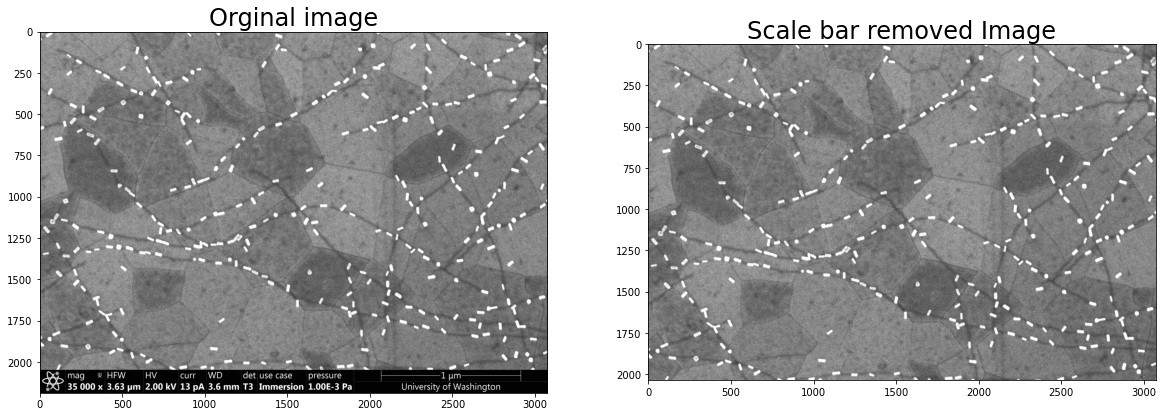

In [7]:
sem=label_cutter(sem_path)


## 3- Identifying Au nanorods

Let's check whether Method 1 (particles_method1) works for particle analysis

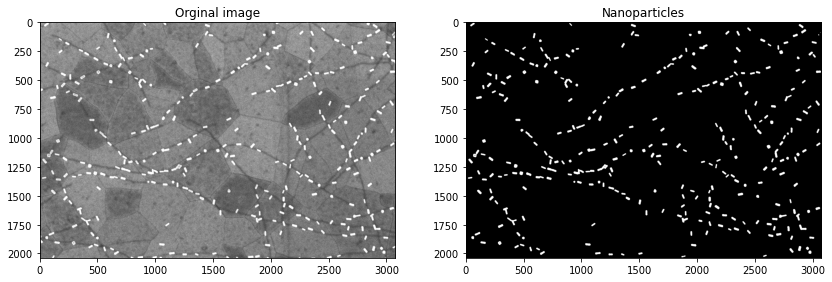

In [8]:
#define output as a "particles" 
particles=particles_method1(sem)
if saving_condition==1:

  cv2.imwrite(filepath+filename+'_particles.png',particles)
  # cv2.imwrite('40_s1_009_sem.png',sem)

Method 1 works most of the time. If Method 1 does not work, let's try Method 2 (particles_method2) 

In [9]:
##uncomment to run and use the output
# particles_method2(sem)
#if you want to use this output for furhter characterization
# particles=particles_method2(sem)

Choose the best method for particle analysis

*   Method 1 
*   Method 2



## 4- Identifying Protein Fibers

### Predicting Protein Fiber

Load trained weights into a model skeleton:

In [10]:
model = resatomsegnet(nb_filters=16)

model = load_torchmodel('/content/fibers-resatomsegnet-3-epoch-377.pt', model)

Load the ground truth image of protein fiber for comparison   

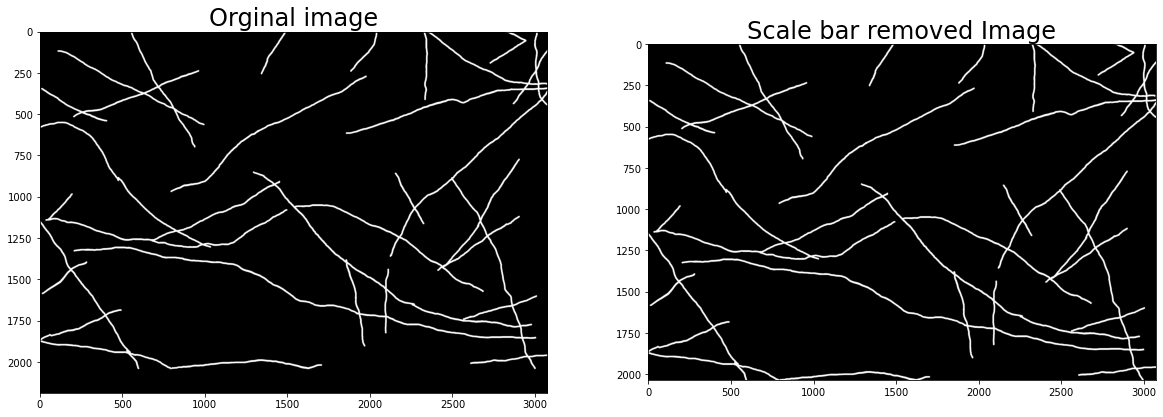

In [11]:
fiber_path='/content/My040_s1_009_pf.jpg'

fiber=label_cutter(fiber_path)

Make a prediction with the model:

In [12]:
semimage=sem
fiberimage=fiber
#resize the images
sem_im_resized = resize(semimage, (512,512))
fiber_im_resized = resize(fiberimage, (512,512))

#converting to array
test_img = np.array(sem_im_resized)
test_label = np.array(fiber_im_resized)

# Specify filepaths fot image and label
# imagefile = '/content/drive/My Drive/training data/all_images/sem_6.npy'
# labelfile = '/content/drive/My Drive/training data/all_images/fibers_6.npy'
# Load data
# test_img = np.load(imagefile)
# test_label = np.load(labelfile) # need only for comparison
# Normalize
test_img_ = (test_img - np.amin(test_img)) / np.ptp(test_img)
# Convert to 4D tensor (required, even if it is a single image)
test_img_ = test_img_.reshape(1, 1, test_img_.shape[0], test_img_.shape[1])
# Convert to pytorch format
test_img_ = torch.from_numpy(test_img_).float()
# Make a prediction
test_img_pred = model.forward(test_img_)
# Convert predicted data to a numpy array
test_img_pred = test_img_pred.detach().numpy()

Plot results:

Text(0.5, 1.0, 'Ground truth')

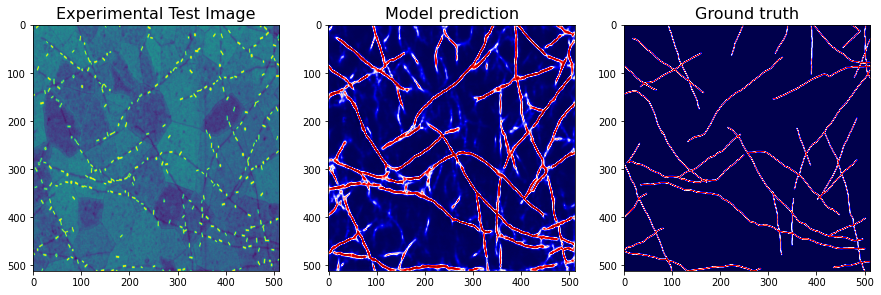

In [13]:
thresh = 0.5
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(test_img[:, :])
ax1.set_title('Experimental Test Image', fontsize=16)
ax2.imshow(test_img_pred[0, 0, :, :], cmap='seismic')
ax2.set_title('Model prediction', fontsize=16)
ax3.imshow(test_label[:, :], cmap='seismic')
ax3.set_title('Ground truth', fontsize=16)

Do some refinement:

Text(0.5, 1.0, 'Ground truth')

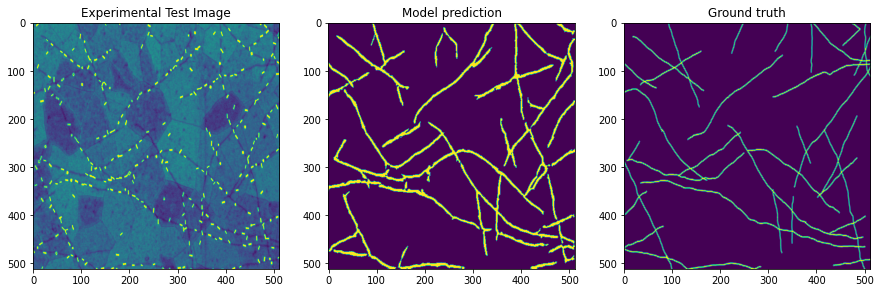

In [14]:
import cv2
from scipy import ndimage

def filter_isolated_cells(imgdata, filter='below', th=250): #maybe above, check image
    '''Filters out blobs above cetrain size
    in the thresholded neural network output'''
    label_img, cc_num = ndimage.label(imgdata)
    cc_areas = ndimage.sum(imgdata, label_img, range(cc_num + 1))
    if filter == 'above':
        area_mask = (cc_areas > th)
    else:
        area_mask = (cc_areas < th)
    label_img[area_mask[label_img]] = 0
    label_img[label_img > 0] = 1
    return label_img

_, test_img_pred_t = cv2.threshold(test_img_pred[0, 0, :, :], .5, 1, cv2.THRESH_BINARY)
# test_img_pred_t = ndimage.binary_erosion(test_img_pred_t, iterations=2)
test_img_pred_f = filter_isolated_cells(test_img_pred_t)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(test_img[:, :, ])
#ax1.imshow(test_img_pred_f, cmap='jet', alpha=.35)
ax1.set_title('Experimental Test Image')
ax2.imshow(test_img_pred_f)
ax2.set_title('Model prediction')
ax3.imshow(test_label[:, :, ])
ax3.set_title('Ground truth')
# plt.savefig('model_prediction.png', transparent= True)

Resize the predicted images

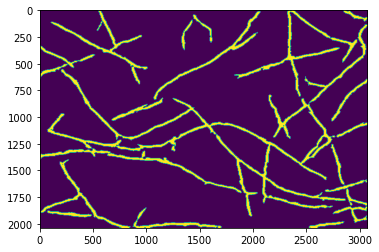

In [15]:
#resize the predicted image
y,x=particles.shape
fiber_im=(test_img_pred_f*255).astype('uint8')
fiber_im_re=cv2.resize(fiber_im,(x,y), interpolation = cv2.INTER_AREA)
# # Creating kernel 
# kernel = np.ones((10,10), np.uint8) 
  
# # Using cv2.erode() method  
# image_cv2 = cv2.erode(fiber_im_re, kernel)  

plt.imshow(fiber_im_re)
#saving the fiber both predicted and resized
# cv2.imwrite('/content/drive/My Drive/Ginger Group/lab notebook/SEM DATA ALL/analyzed data/angle_calculated_data/40_s1_009_fiber.png', fiber/2)
# cv2.imwrite('/content/drive/My Drive/Ginger Group/lab notebook/SEM DATA ALL/analyzed data/angle_calculated_data/40_s1_009_fiber_predict.png', fiber_im/2)
# cv2.imwrite('/content/drive/My Drive/Ginger Group/lab notebook/SEM DATA ALL/analyzed data/angle_calculated_data/40_s1_009_fiber_predict_resized.png', fiber_im_re/2)
# cv2.imwrite('/content/drive/My Drive/Ginger Group/lab notebook/SEM DATA ALL/analyzed data/angle_calculated_data/40_s1_009_fiber_predict1.png', image_cv2)

Calculation of the length of Protein Fiber

total length of protein fiber 35488 nm


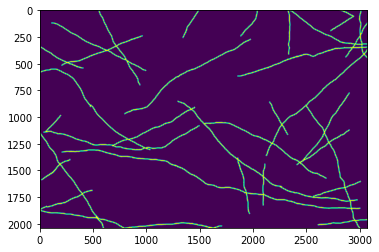

In [16]:
fiber_perimeters(fiber)
if saving_condition==1:
  
  cv2.imwrite(filepath+filename+'_fiber.png', fiber/2)
  cv2.imwrite(filepath+filename+'_sem.png', sem)

total length of protein fiber 42355 nm


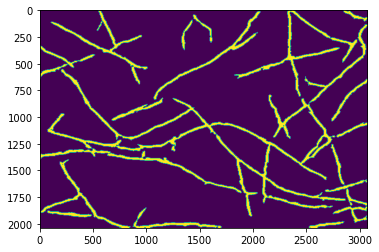

In [17]:
fiber_perimeters(fiber_im_re)
if saving_condition==1:
  
  cv2.imwrite(filepath+filename+'_fiber_predict_resized.png', fiber_im_re/2)

Rebuilt the image from particle and fiber images

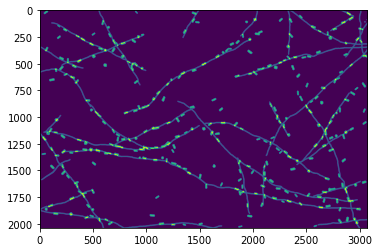

In [18]:
im2=particles+fiber/2
plt.imshow(im2)

if saving_condition==1:
  
  cv2.imwrite(filepath+filename+'_resento_fiber.png', im2)

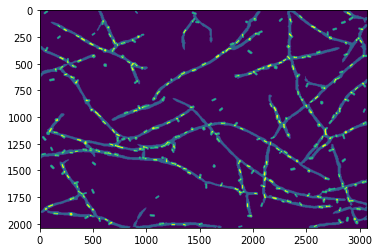

In [19]:
im20=particles+fiber_im_re/2
plt.imshow(im20)

if saving_condition==1:
  cv2.imwrite(filepath+filename+'_resento_prefiber.png', im20)

## 5- Finding Angle of each attached Au nanorod with respect to Protein Fibers

Calculating specific vs nonspecific Au nanorods attachment to protein fiber and the angle of each attached Au nanorod on protein fiber

total length of protein fiber 35488 nm


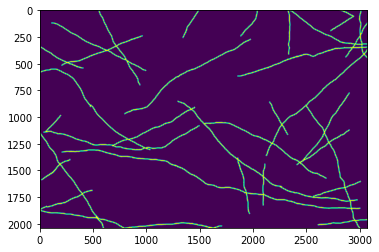

In [20]:

(count_particleonPF,particle_num,nm_sum_pf, sum_perimeter_pf), df_gro, im_gro=angle_calculation(particles,fiber)

In [21]:
print('Total number of Au NR : ', particle_num) 
print('Number of Au NR on protein fiber: ', count_particleonPF)
print('Number of Au NR on the substrate:' , particle_num-count_particleonPF)
df_gro

Total number of Au NR :  297
Number of Au NR on protein fiber:  226
Number of Au NR on the substrate: 71


,Particle number,Center of Au particle on X,Center of Au particle on Y,Width of Au particle,Height of Au particle,Aspect Ratio of Au particle,Area of Au particle,Angle of Au particle (°),Angle of Au particle_90 (°),Angle of Protein fiber (°),Angle of Intersection (°)
0,3,1247,2006,17.000000,36.000000,2.117647,524,89.765968,89.765968,-6.961925,6.727893
1,4,1504,1998,16.335821,36.494919,2.234043,486,80.180351,80.180351,11.789893,21.609542
2,5,1137,1996,17.831184,48.096375,2.697318,713,83.991562,83.991562,-2.032764,3.975674
3,6,658,1993,19.767191,44.396328,2.245960,705,59.971298,59.971298,17.086995,47.115697
4,7,2967,1987,25.000000,28.000000,1.120000,586,174.556625,5.443375,53.419192,31.137434
...,...,...,...,...,...,...,...,...,...,...,...
223,292,2013,88,28.000000,28.000000,1.000000,647,127.251030,52.748970,-60.747037,82.001933
224,293,2913,79,20.246559,46.872169,2.315068,817,55.504971,55.504971,-51.566592,17.071562
225,294,2442,62,14.849242,38.183762,2.571428,485,134.649902,45.350098,39.693446,4.956456
226,295,2891,34,19.137157,44.930717,2.347826,721,124.598900,55.401100,36.759288,2.160388


total length of protein fiber 42355 nm


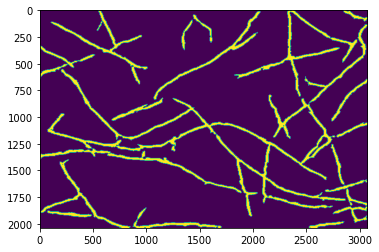

In [22]:
(count_particleonPF1,particle_num1,nm_sum_pf1, sum_perimeter_pf1), df_pre, im_pre=angle_calculation(particles,fiber_im_re)

In [23]:
print('Total number of Au NR : ', particle_num1) 
print('Number of Au NR on protein fiber: ', count_particleonPF1)
print('Number of Au NR on the substrate:' , particle_num-count_particleonPF1)
df_pre

Total number of Au NR :  297
Number of Au NR on protein fiber:  267
Number of Au NR on the substrate: 30


,Particle number,Center of Au particle on X,Center of Au particle on Y,Width of Au particle,Height of Au particle,Aspect Ratio of Au particle,Area of Au particle,Angle of Au particle (°),Angle of Au particle_90 (°),Angle of Protein fiber (°),Angle of Intersection (°)
0,1,2578,2018,12.046443,31.269489,2.595745,315,72.381454,72.381454,-8.080468,9.538077
1,2,1351,2006,13.914022,30.674095,2.204545,338,109.666077,70.333923,2.423968,17.242108
2,3,1247,2006,17.000000,36.000000,2.117647,524,89.765968,89.765968,-0.671623,0.437591
3,4,1504,1998,16.335821,36.494919,2.234043,486,80.180351,80.180351,13.477385,23.297034
4,5,1137,1996,17.831184,48.096375,2.697318,713,83.991562,83.991562,-10.496822,4.488384
...,...,...,...,...,...,...,...,...,...,...,...
274,290,2347,96,16.994116,44.721359,2.631579,633,153.599380,26.400620,81.410400,17.811019
275,292,2013,88,28.000000,28.000000,1.000000,647,127.251030,52.748970,-45.102430,82.353460
276,293,2913,79,20.246559,46.872169,2.315068,817,55.504971,55.504971,23.808240,58.303270
277,294,2442,62,14.849242,38.183762,2.571428,485,134.649902,45.350098,41.988243,2.661659


### Save the result of analysis

In [24]:
if saving_condition==1:

  df_gro.to_csv(filepath+filename+'_analyzed_ground.csv')
  df_pre.to_csv(filepath+filename+'_analyzed_predicted.csv')

### Error Calculation of Protein Fiber

Total # of Au Particles :  297
Total # of Au Particles on Ground Truth Protein Fiber :  226
Total # of Au Particles on Predicted Protein Fiber : 267


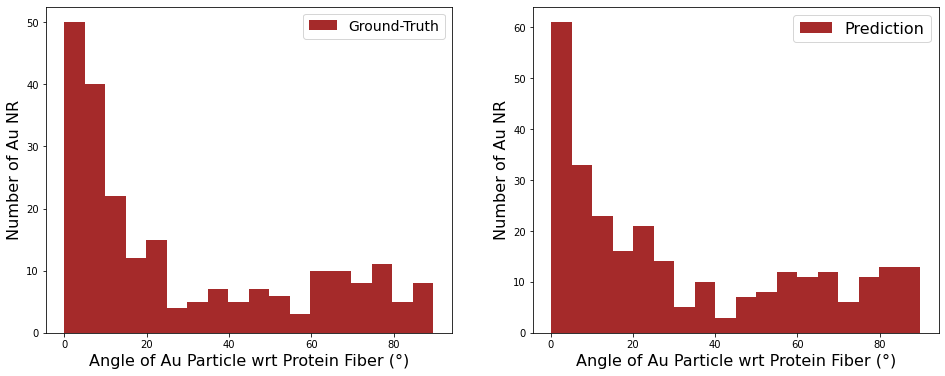

In [25]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].hist(df_gro['Angle of Intersection (°)'], bins=18, color='brown', label=('Ground-Truth'))
ax[0].set_xlabel('Angle of Au Particle wrt Protein Fiber (°)', fontsize=16)
ax[0].set_ylabel('Number of Au NR', fontsize=16)
ax[0].legend(fontsize=14)


ax[1].hist(df_pre['Angle of Intersection (°)'], bins=18, color='brown', label=('Prediction'))
ax[1].set_xlabel('Angle of Au Particle wrt Protein Fiber (°)', fontsize=16)
ax[1].set_ylabel('Number of Au NR', fontsize=16)
ax[1].legend(fontsize=16)



print("Total # of Au Particles : ", particle_num)
print("Total # of Au Particles on Ground Truth Protein Fiber : ", count_particleonPF)
print("Total # of Au Particles on Predicted Protein Fiber :", count_particleonPF1)


#save the figure

plt.savefig(filepath+filename+'_output.png',transparent=True)

calculate Mean Square Error (MSE):

In [26]:
summary=0
dif_ang=[]
gro_an=[]
pre_an=[]
n=len(df_gro)
for i in range(len(df_gro)):
  x=df_gro['Center of Au particle on X'][i]
  y=df_gro['Center of Au particle on Y'][i]
  gro_ang=df_gro['Angle of Intersection (°)'][i]
  pre_ang=df_pre[(df_pre['Center of Au particle on X']==x) & (df_pre['Center of Au particle on Y']==y)]['Angle of Intersection (°)'].to_numpy()
  
  gro_an.append(gro_ang)
  pre_an.append(pre_ang)

  diff=pre_ang-gro_ang
  dif_ang.extend(diff)
  # squ_diff=diff**2
  # summary=summary+squ_diff
# MSE=summary/n
df_MSE=pd.DataFrame({'ground':gro_an,
                     'predict':pre_an})
sum_a=0
sum_m=0
n=len(dif_ang)
for i in range(len(dif_ang)):
  x=dif_ang[i]
  if np.abs(x)<90:
    sq=x**2
    sum_a=sum_a+sq

    sum_m=sum_m+np.abs(x)


MSE= sum_m/n
RMSE=np.sqrt(sum_a/n)

print("MSE Error in Angle Calculation: ", f'{MSE:.3}')



MSE Error in Angle Calculation:  9.38


THE END !!!